# **Advanced Techniques in Data Analysis - MACHINE LEARNING PROJECT** 

## Objectives and Motivation

In this project we want to make a deep dive into the world of stock prediction, more specifically on the PayPal stock. Our objectives:

- Make a rigorous time series analysis 

- Make a classifier to evaluate if the stock will go up or down

- Risk management

# Importing the Paypal Stock information

## Imports and Data Cleaning

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import sklearn.svm as svc
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

Now we download the Standard & Poor 500 dataset (or keep it updated)

In [124]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yash16jr/s-and-p500-daily-update-dataset")

print("Path to dataset files:", path)

100%|██████████| 65.8M/65.8M [00:02<00:00, 26.4MB/s]

Extracting files...


Path to dataset files: /Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/299


In [125]:

import os

path = "/Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/275"

print(os.listdir(path))

['SnP_daily_update.csv']


In [126]:

df = pd.read_csv(
    
    '/Users/guilhermealves/.cache/kagglehub/datasets/yash16jr/s-and-p500-daily-update-dataset/versions/275/SnP_daily_update.csv',
    
    header=[0, 1],         
    index_col=0,          
    parse_dates=True      
)

print(df.head())


Price           Close                                                      \
Ticker              A      AAPL ABBV ABNB        ABT      ACGL        ACN   
Date                                                                        
2010-01-04  19.891678  6.424604  NaN  NaN  18.414782  7.601905  31.492178   
2010-01-05  19.675604  6.435713  NaN  NaN  18.266010  7.576549  31.686796   
2010-01-06  19.605700  6.333346  NaN  NaN  18.367451  7.543795  32.023655   
2010-01-07  19.580280  6.321635  NaN  NaN  18.519613  7.499420  31.993717   
2010-01-08  19.573919  6.363664  NaN  NaN  18.614286  7.484628  31.866457   

Price                                        ...   Volume                    \
Ticker           ADBE        ADI        ADM  ...       WY     WYNN      XEL   
Date                                         ...                              
2010-01-04  37.090000  21.975159  20.614487  ...  1832400  4741400  2670400   
2010-01-05  37.700001  21.940468  20.725853  ...  1724500  5644300 

In [127]:
df_pypl_completo = df.xs('PYPL', level=1, axis=1)

In [128]:
df_pypl_completo.columns = [col.lower() for col in df_pypl_completo.columns]

if 'price' in df_pypl_completo.columns:
    df_pypl_completo = df_pypl_completo.drop(columns=['price'])

df_pypl_completo.dropna(subset=['close'], inplace=True)

df_pypl = df_pypl_completo.copy()

print("PayPal's DataFrame (PYPL) Clean and Ready:")
print(df_pypl.head())
print(f"Column number: {df_pypl.shape[1]}")
print(f"Existent Columns: {list(df_pypl.columns)}")


PayPal's DataFrame (PYPL) Clean and Ready:
                close       high        low       open     volume
Date                                                             
2015-07-06  36.709999  39.750000  36.000000  38.000000  5866600.0
2015-07-07  36.619999  37.810001  36.000000  37.720001  7359000.0
2015-07-08  34.700001  36.360001  34.529999  36.340000  5387700.0
2015-07-09  34.500000  35.520000  33.990002  35.099998  3760100.0
2015-07-10  34.689999  35.189999  33.980000  34.660000  4472800.0
Column number: 5
Existent Columns: ['close', 'high', 'low', 'open', 'volume']


# Time Series Analysis


Stock market predicition must be preceded by a rigorous Time Series Analysis. Financial data is unique because observations are not independent and identifcally distributed, they exibit autocorrelation and non-stationarity.


Time Series Analysis serves two critical functions:

- Risk Management: Quantifying extreme events. This will provide context for interpreting machine learning models.

- Validation and feature engineering: It allow us to confirm the statistical properties of data (Stationarity and other)

## Discrete Analysis

### Logarithmic Return 

### Histogram of returns

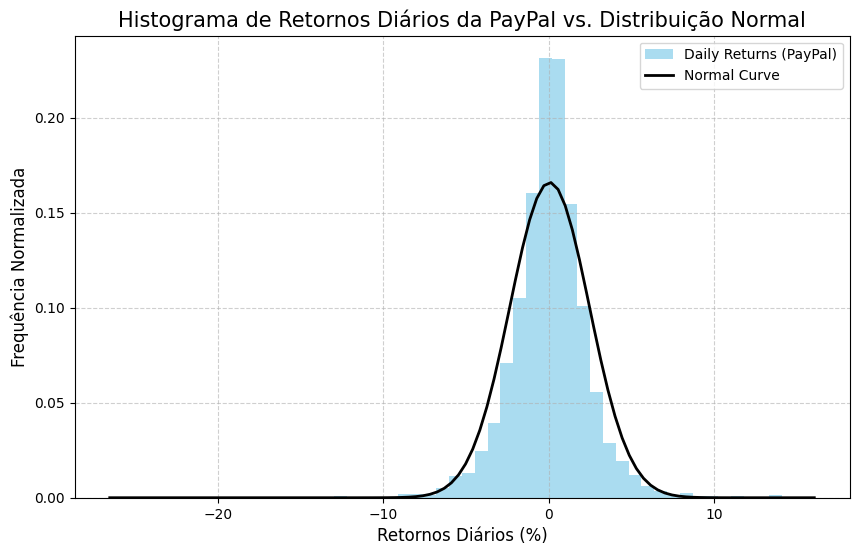

In [129]:
ret = 100 * (df_pypl['close'].pct_change())
plt.figure(figsize=(10,6))
plt.hist(ret, bins=50, density = True, label = "Daily Returns (PayPal)", color = "skyblue", alpha=0.7)

from scipy.stats import norm

mu, sigma = ret.mean(), ret.std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma) 


plt.plot(x, p, 'k', linewidth=2, label='Normal Curve')


title = "Histograma de Retornos Diários da PayPal vs. Distribuição Normal"
plt.title(title, fontsize=15)
plt.xlabel("Retornos Diários (%)", fontsize=12)
plt.ylabel("Frequência Normalizada", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [130]:
from scipy.stats import jarque_bera, skew, kurtosis
import pandas as pd


ret_clean = ret.dropna() 


jb_result = jarque_bera(ret_clean)
jb_statistic = jb_result[0]
jb_pvalue = jb_result[1]


skewness_value = skew(ret_clean)

kurtosis_value = kurtosis(ret_clean, fisher=False) 

print(f"Estatística Jarque-Bera: {jb_statistic:.4f}")
print(f"P-value: {jb_pvalue:.4f}")
print(f"Assimetria (Skewness): {skewness_value:.4f}")
print(f"Curtose (Kurtosis): {kurtosis_value:.4f}")

# Regra de Decisão
if jb_pvalue <= 0.05:
    print("Conclusão: Rejeitamos a Hipótese Nula (H0). Os retornos NÃO são normalmente distribuídos (devido a caudas gordas ou assimetria).")
else:
    print("Conclusão: Não rejeitamos H0.")

Estatística Jarque-Bera: 8116.4353
P-value: 0.0000
Assimetria (Skewness): -0.3848
Curtose (Kurtosis): 11.6415
Conclusão: Rejeitamos a Hipótese Nula (H0). Os retornos NÃO são normalmente distribuídos (devido a caudas gordas ou assimetria).


## Stationary Test

## Time Dependency Analysis

# PayPal Stock Prediction using a Support Vector Machine 


The idea of Support Vector Machine is by finding a hyperplane to divide the data into groups, this will classify if the stock is going up or down based on historic data.

This only shows history up to 2015-07-06 because PayPal only turned public in July of 2015 (The S&P500 file starts at 2010)

Since the Support Vector Machine is a classifier we need to define the target

- 1 if tomorrow's price is BIGGER than today
- 0 if tomorrow's price is SMALLER than today

In [131]:
df_pypl["Target"]= np.where(df_pypl["close"].shift(-1) > df_pypl["close"], 1, 0)

In [132]:
df_pypl["SMA_20"]= df_pypl["close"].rolling(window=20).mean()

In [133]:
df_pypl["SMA_50"]=df_pypl["close"].rolling(window=50).mean()

In [134]:
df_ml_final = df_pypl.dropna()

In [135]:
features = ["open", "high", "low", "close", "volume", "SMA_20", "SMA_50"]
X = df_ml_final [features]
y = df_ml_final["Target"]

In [136]:
print( "DataFrame da Paypal com features e Target")
print(df_ml_final[features + ["Target"]].tail())
print(f"\nNúmero de amostras prontas para o SVM (X e y): {X.shape[0]}")
print(f"Número de Features (X): {X.shape[1]}")

DataFrame da Paypal com features e Target
                 open       high        low      close      volume   SMA_20  \
Date                                                                          
2025-10-13  70.720001  70.930000  68.162003  68.860001  20036800.0  69.3580   
2025-10-14  67.410004  69.709999  66.769997  69.150002  12968500.0  69.4730   
2025-10-15  69.385002  69.875000  67.839996  67.980003  11247300.0  69.4410   
2025-10-16  68.129997  68.599998  65.419998  66.050003  19258500.0  69.3175   
2025-10-17  65.535004  67.709999  65.449997  67.410004  11141800.0  69.2770   

             SMA_50  Target  
Date                         
2025-10-13  68.8970       1  
2025-10-14  68.9198       0  
2025-10-15  68.9228       0  
2025-10-16  68.8554       1  
2025-10-17  68.8392       0  

Número de amostras prontas para o SVM (X e y): 2540
Número de Features (X): 7


In [137]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, shuffle=False)

In [138]:
np.random.seed(42)
num_samples= X.shape[0]

scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [139]:
model = SVC (kernel= "rbf", C=1.0, gamma = "scale", random_state=42)

In [140]:
model.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [141]:
y_pred = model.predict(X_test_scaled)

In [142]:
print(accuracy_score(y_test, y_pred))

0.5511811023622047


In [143]:
cm= confusion_matrix(y_test, y_pred)
print(cm)

[[ 29 209]
 [ 19 251]]


In [144]:
print(classification_report(y_test, y_pred, target_names=['DOWN (0)', 'UP (1)']))

              precision    recall  f1-score   support

    DOWN (0)       0.60      0.12      0.20       238
      UP (1)       0.55      0.93      0.69       270

    accuracy                           0.55       508
   macro avg       0.57      0.53      0.45       508
weighted avg       0.57      0.55      0.46       508



# Risk Management on PayPal Stocks

Risk Management is fundamental to predict the behavior of stocks. Markowitz stated in his famous book, that volatility, which was a phenomenon not closely linked to math, to be the standard deviation of returns, $\sigma_r$.

There are Several methods to predict volatility, we will start with 2 classical ones and then move to a machine learning approach, with support vector regressors and neural networks. 

But first we will calculate the return volatility by using the formula for the Realized Volatility:

$$ \sigma=\sqrt{\frac{1}{n-1}\sum_{n=1}^N (r_n -\mu_r)^2} $$

where $N$ is the number of observations, $r_n$ is the return at observation $n$ and $\mu_r$ is the average return

In [145]:
ret = 100 * (df_pypl['close'].pct_change()).dropna()
realized_vol = ret.rolling(5).std()

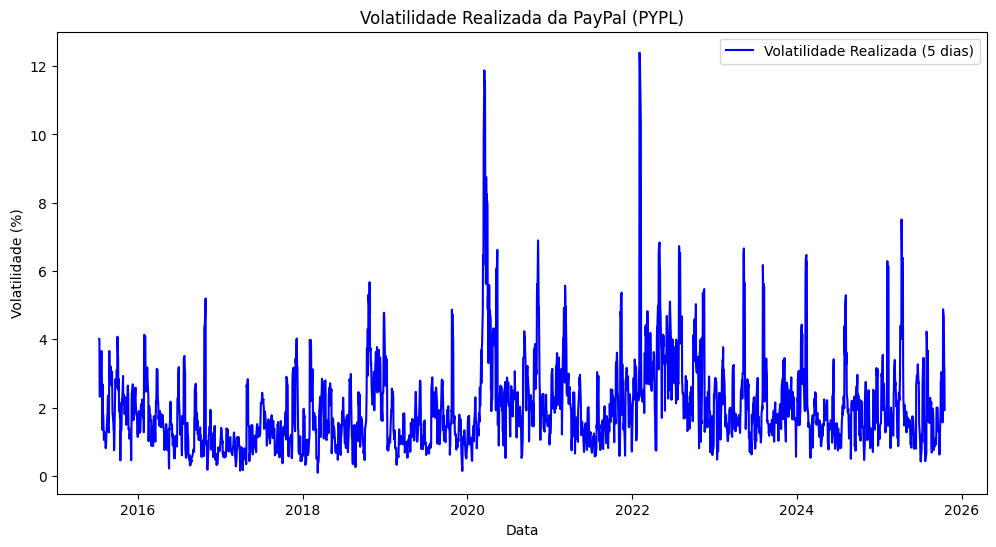

In [146]:
plt.figure(figsize=(12, 6))
plt.plot(realized_vol, label='Volatilidade Realizada (5 dias)', color='blue')
plt.title('Volatilidade Realizada da PayPal (PYPL)')
plt.xlabel('Data')
plt.ylabel('Volatilidade (%)')
plt.legend()
plt.show()

This is interesting because we can see big spikes on 2020 and 2022:

- 2020: Begining of the COVID pandemic

- 2022: A shocking report about the Q4 2021 was released. The sharp drop was due to the company drastically cutting its growth forecasts.

In [147]:
retv = ret.values

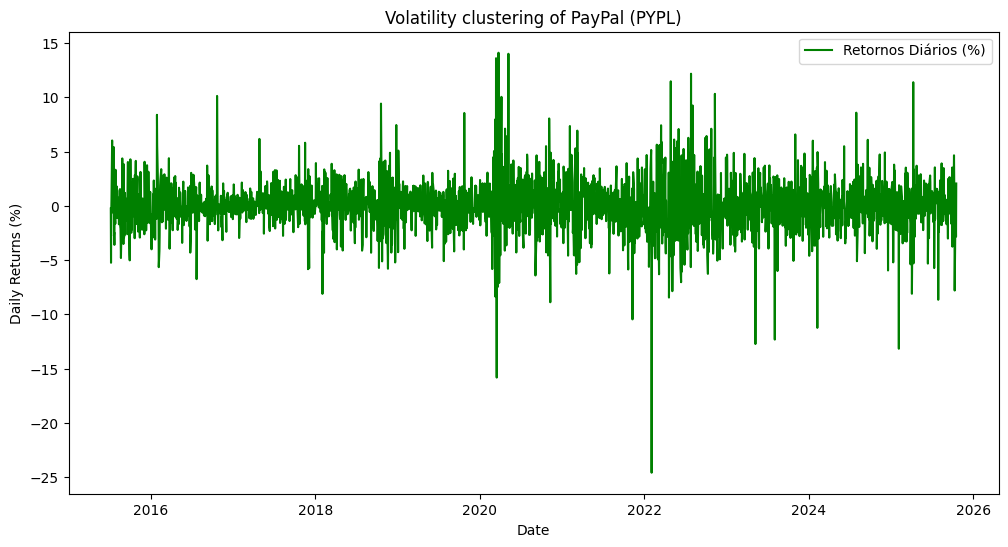

In [148]:
plt.figure(figsize=(12, 6))
plt.plot(df_pypl.index[1:], retv, label='Retornos Diários (%)', color='green')
plt.title('Volatility clustering of PayPal (PYPL)')
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.legend()
plt.show()

with this volatility clustering we can now in which direction was the spikes on 2020 and 2022 (downwards)

## ARCH Model

The ARCH model was one of the first statistical models introduced to predict volatility: the ARCH model is a univariate model and based on historical asset returns

$$\sigma_t ^2 = \omega + \sum_{k=1}^p \alpha_k (r_{t - k})^2$$

where the mean model is:

$$ r_t = \sigma_t \epsilon_t $$

where $\epsilon_t$ is assumed to be normally distributed

In this project we will not implement the ARCH model from the ground, instead we will use the arch library

In [149]:
from arch import arch_model
from sklearn.metrics import mean_squared_error as mse

In [150]:
arch = arch_model(ret, mean="Zero", vol="ARCH", p=1).fit(disp="off")
print(arch.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5888.04
Distribution:                  Normal   AIC:                           11780.1
Method:            Maximum Likelihood   BIC:                           11791.8
                                        No. Observations:                 2588
Date:                Sun, Nov 16 2025   Df Residuals:                     2588
Time:                        22:32:15   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          4.7301      0.333     14.220  6.907e-46   [  4.07

In [151]:
n=252
split_date=ret.iloc[-n:].index


In [152]:
bic_arch = []
for p in range(1, 5):
    arch = arch_model(ret, mean='zero', vol='ARCH', p=p).fit(disp='off')
    bic_arch.append(arch.bic)
    if arch.bic == np.min(bic_arch):
        best_param = p
arch = arch_model(ret, mean='zero', vol='ARCH', p=best_param).fit(disp='off')
print(arch.summary())

forecast_arch = arch.forecast(start=split_date[0])


                        Zero Mean - ARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -5775.02
Distribution:                  Normal   AIC:                           11560.0
Method:            Maximum Likelihood   BIC:                           11589.3
                                        No. Observations:                 2588
Date:                Sun, Nov 16 2025   Df Residuals:                     2588
Time:                        22:32:15   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          2.7909      0.324      8.625  6.405e-18    [  

In [153]:
rmse_arch=np.sqrt(mse(realized_vol[-n:] /100 , np.sqrt(forecast_arch.variance.iloc[-len(split_date): ] /100 )))
print(f"RMSE for ARCH model: {rmse_arch}")

RMSE for ARCH model: 0.22280268870871786


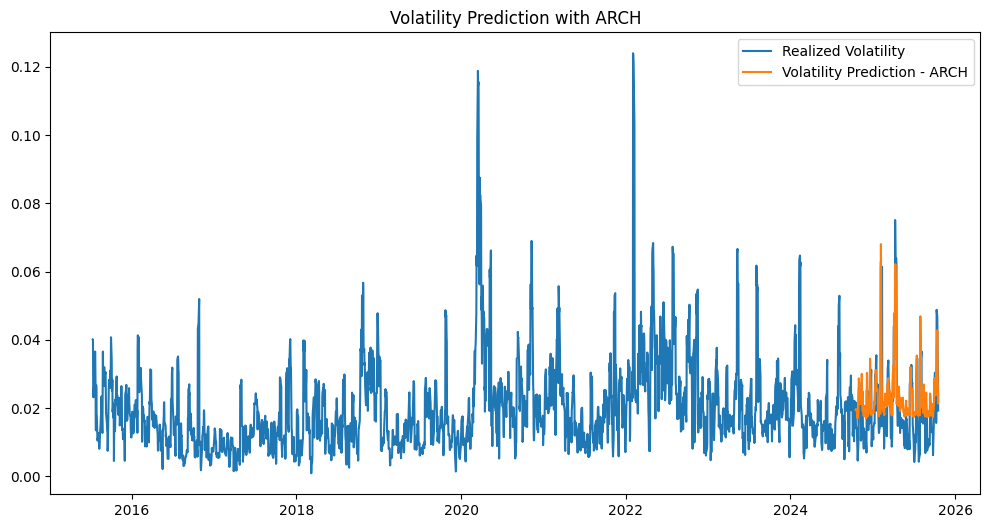

In [154]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol /100 , label= "Realized Volatility")
plt.plot(np.sqrt(forecast_arch.variance.iloc[-len(split_date):]) /100 , label = "Volatility Prediction - ARCH")
plt.title("Volatility Prediction with ARCH", fontsize = 12)
plt.legend()
plt.show()

As we can see we got a nice prediction of the volatility, even using an old model such as ARCH.

Disadvantages of using ARCH:
- Needs a lot of parameters: Markets are complex, and ARCH model can not capture all the shocks of volatility in data using a small $p$. To get a good modelation, a higher $p$ would be necessary

- Non-negativity: Two of the assumptions of ARCH are that $\alpha_k$ and $\omega$ are $>0$ which turns the volatility hard to model.

- Information assimetry: ARCH only looks for past returns, $r_{t-k} ^2$ to predict future volatility, $\sigma_t ^2$, but ignores the direction of the shock. This means that the model cannot capture the leverage effect: Bad news tend to a higher volatility and good news tends to lower volatility.

## GARCH model

GARCH is an extension of ARCH incorporating lagged conditional variance. This makes the model multivariate in the sense that it is an autoregressive moving average model.

In [155]:
bic_garc= []

for p in range (1,5):
    for q in range(1,5):
        garch = arch_model(ret, mean="zero", vol="GARCH", p=p, o=0, q=q).fit(disp="off")
        bic_garc.append(garch.bic)
        if garch.bic == np.min(bic_garc):
            best_param = (p,q)
garch = arch_model(ret, mean="zero", vol="GARCH", p=best_param[0], o=0, q=best_param[1]).fit(disp="off")
print(garch.summary())
forecast_garch = garch.forecast(start=split_date[0])
forecast_garch 

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5726.47
Distribution:                  Normal   AIC:                           11462.9
Method:            Maximum Likelihood   BIC:                           11492.2
                                        No. Observations:                 2588
Date:                Sun, Nov 16 2025   Df Residuals:                     2588
Time:                        22:32:16   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.3959      0.167      2.371  1.775e-02 [6.861e-0

In [156]:
rmse_garch = np.sqrt(mse(realized_vol[-n:] /100 , np.sqrt(forecast_garch.variance.iloc[-len(split_date): ] /100 )))
print(f"RMSE for GARCH model: {rmse_garch}")

RMSE for GARCH model: 0.21786483950111737


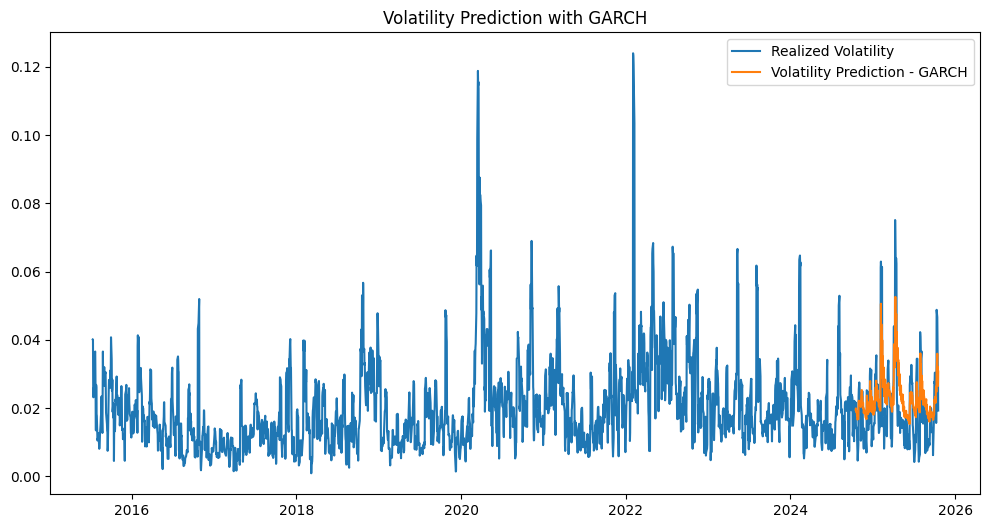

In [157]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol /100 , label= "Realized Volatility")
plt.plot(np.sqrt(forecast_garch.variance.iloc[-len(split_date):]) /100 , label = "Volatility Prediction - GARCH")
plt.title("Volatility Prediction with GARCH", fontsize = 12)
plt.legend()
plt.show()

We can see that GARCH got a slight better value than ARCH, but still a bad value.

## Support Vector Regression with GARCH

We can use machine learning to get the optimized parameters, 

In [158]:
from sklearn.svm import SVR
from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV

In [159]:
realized_vol = ret.rolling(5).std()
realized_vol = pd.DataFrame(realized_vol)
realized_vol.reset_index(drop=True, inplace=True)


In [160]:
returns_svm = ret ** 2
returns_svm = returns_svm.reset_index()
del returns_svm["Date"]

In [161]:
X = pd.concat([realized_vol, returns_svm], axis=1, ignore_index=True)
X = X[4:].copy()
X = X.reset_index()
X.drop("index", axis=1, inplace=True)

In [162]:
realized_vol = realized_vol.dropna().reset_index()
realized_vol.drop("index", axis=1, inplace=True)

In [163]:
svr_poly=SVR(kernel="poly", degree=2)
svr_lin=SVR(kernel="linear")
svr_rbf=SVR(kernel="rbf")

In [164]:
para_grid = {'gamma': sp_rand(), 'C': sp_rand(), 'epsilon': sp_rand()}
clf_lin = RandomizedSearchCV(svr_lin, para_grid, n_jobs=-1)
clf_lin.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_lin = clf_lin.predict(X.iloc[-n:])

In [165]:
predict_svr_lin = pd.DataFrame(predict_svr_lin)
predict_svr_lin.index = ret.iloc[-n:].index

In [166]:
rmse_svr = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_lin / 100))
print(f"RMSE for SVR model: {rmse_svr}")

RMSE for SVR model: 0.0014294715991042873


In [167]:
realized_vol.index=ret.iloc[4:].index

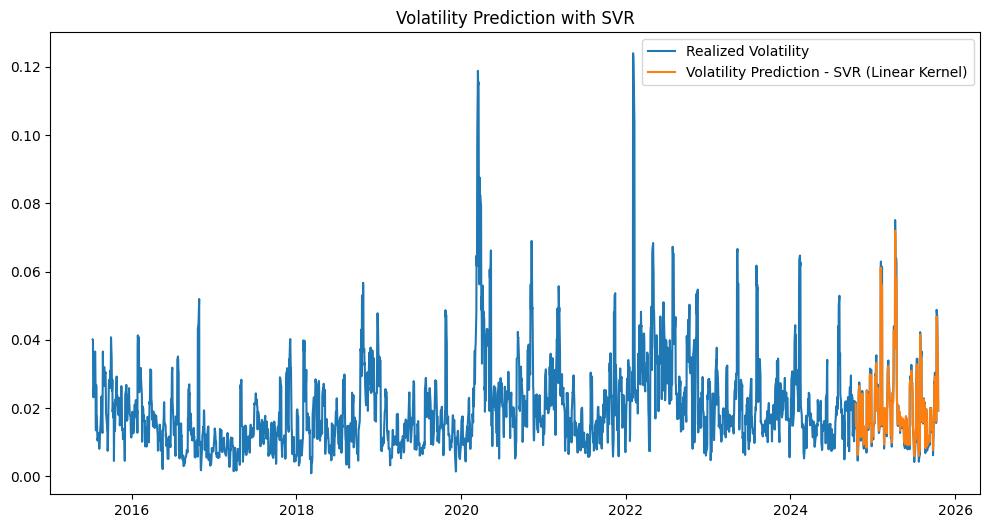

In [168]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(predict_svr_lin / 100, label="Volatility Prediction - SVR (Linear Kernel)")
plt.title("Volatility Prediction with SVR", fontsize=12)
plt.legend()
plt.show()

In [169]:
clf_rbf = RandomizedSearchCV(svr_rbf, para_grid, n_jobs=-1)
clf_rbf.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,))
predict_svr_rbf = clf_rbf.predict(X.iloc[-n:])

In [170]:
predict_svr_rbf = pd.DataFrame(predict_svr_rbf)
predict_svr_rbf.index = ret.iloc[-n:].index

In [171]:
rmse_svr_rbf = np.sqrt(mse(realized_vol.iloc[-n:] / 100, predict_svr_rbf / 100))
print('The RMSE value of SVR with RBF Kernel is {:.6f}'.format(rmse_svr_rbf))

The RMSE value of SVR with RBF Kernel is 0.003021


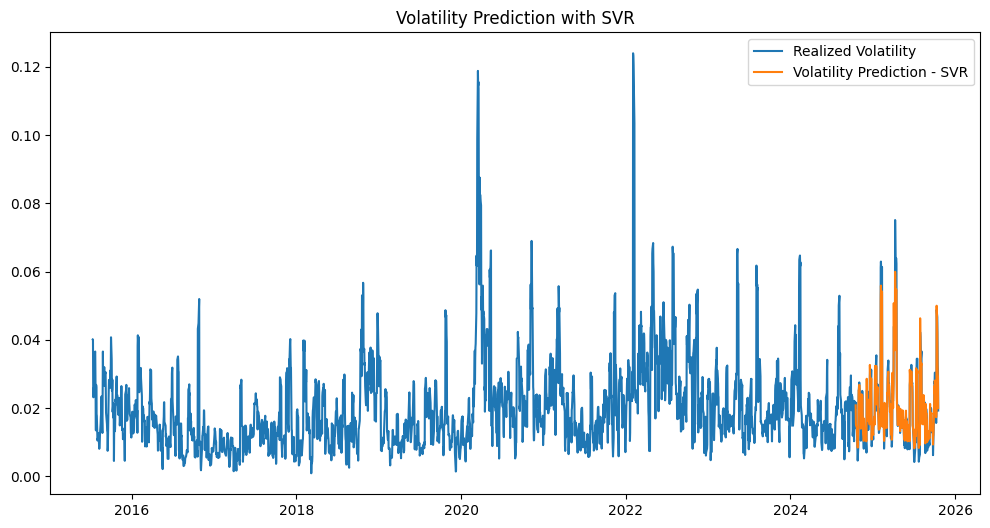

In [172]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(predict_svr_rbf / 100, label="Volatility Prediction - SVR")
plt.title("Volatility Prediction with SVR", fontsize=12)
plt.legend()
plt.show()

## Neural Networks on GARCH

In [173]:
from sklearn.neural_network import MLPRegressor
NN_vol = MLPRegressor(learning_rate_init=0.001, random_state=1)
para_grid_NN = {'hidden_layer_sizes': [(100, 50), (50, 50), (10, 100)],'max_iter': [500, 1000],'alpha': [0.00005, 0.0005 ]}
clf_NN = RandomizedSearchCV(NN_vol, para_grid_NN)
clf_NN.fit(X.iloc[:-n].values,realized_vol.iloc[1:-(n-1)].values.reshape(-1, ))
NN_predictions = clf_NN.predict(X.iloc[-n:])

In [174]:
NN_predictions= pd.DataFrame(NN_predictions)
NN_predictions.index=ret.iloc[-n:].index

In [175]:
rmse_svr_nn = np.sqrt(mse(realized_vol.iloc[-n:] / 100, NN_predictions / 100))
print('The RMSE value of Neural Network is {:.6f}'.format(rmse_svr_rbf))

The RMSE value of Neural Network is 0.003021


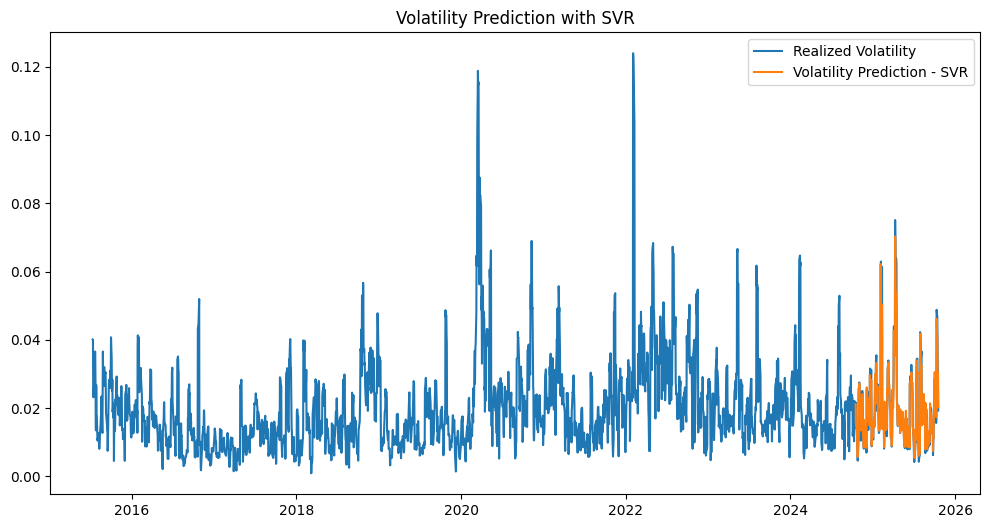

In [176]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(NN_predictions / 100, label="Volatility Prediction - SVR")
plt.title("Volatility Prediction with SVR", fontsize=12)
plt.legend()
plt.show()

## Deep Learning on GARCH

In [177]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 

In [178]:
model = keras.Sequential([layers.Dense(256, activation="relu"), layers.Dense(128, activation="relu"), layers.Dense(1, activation="linear")])

In [179]:
model.compile(loss="mse", optimizer="rmsprop")

In [180]:
epochs_trial= np.arange(100,400,4)
batch_trial= np.arange(100,400, 4)
DL_pred=[]
DL_RMSE=[]
for i, j, k in zip(range(4), epochs_trial, batch_trial):
    model.fit(X.iloc[:-n].values, realized_vol.iloc[1:-(n-1)].values.reshape(-1,), batch_size=k, epochs=j, verbose=False)
    DL_predict = model.predict(np.asarray(X.iloc[-n:]))
    DL_RMSE.append(np.sqrt(mse(realized_vol.iloc[-n:] /100, DL_predict.flatten() /100)))
    DL_pred.append(DL_predict)
    print("DL_RMSE_{}:{:.6f}".format(i+1, DL_RMSE[i]))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
DL_RMSE_1:0.002132
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step
DL_RMSE_2:0.003492
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
DL_RMSE_3:0.003339
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
DL_RMSE_4:0.002232


In [181]:
DL_predict= pd.DataFrame(DL_pred[DL_RMSE.index(min(DL_RMSE))])
DL_predict.index= ret.iloc[-n:].index

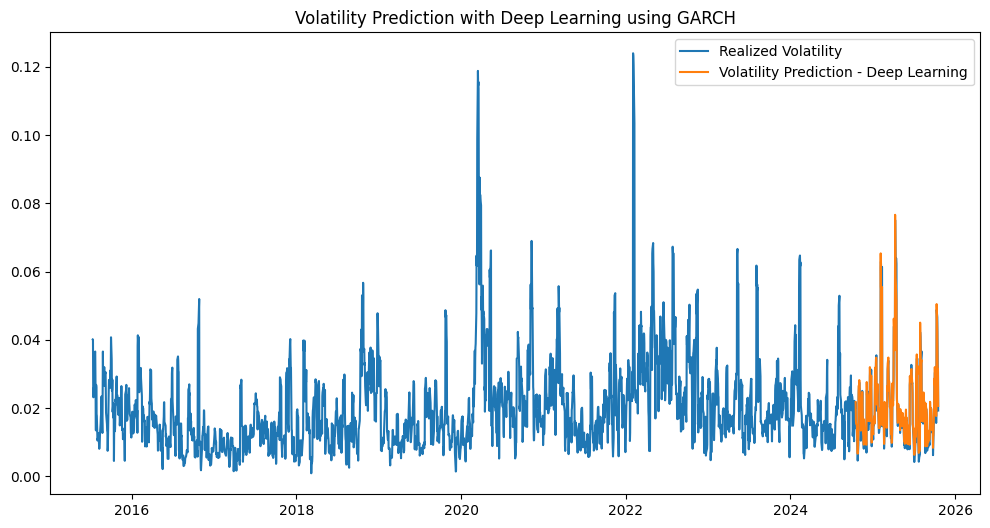

In [182]:
plt.figure(figsize=(12,6))
plt.plot(realized_vol / 100, label="Realized Volatility")
plt.plot(DL_predict / 100, label="Volatility Prediction - Deep Learning")
plt.title("Volatility Prediction with Deep Learning using GARCH", fontsize=12)
plt.legend()
plt.show()

As far as we tested, based on RMSE, a SVR using a linear kernel function was the best method to predict risk on PayPal stocks. This will be a useful feature to implement to predict stock direction.

# Predicting stock direction with LINEAR SVR GARCH  

In [196]:
df_pypl['Predicted_Vol_SVR_Lin'] = predict_svr_lin
df_pypl_vol = df_pypl

In [197]:
features = ["open", "high", "low", "close", "volume", "SMA_20", "SMA_50", "Predicted_Vol_SVR_Lin"]
X = df_pypl_vol [features]
y = df_pypl_vol["Target"]
print( "DataFrame da Paypal com features e Target")
print(df_pypl_vol[features + ["Target"]].tail())
print(f"\nNúmero de amostras prontas para o SVM (X e y): {X.shape[0]}")
print(f"Número de Features (X): {X.shape[1]}")


DataFrame da Paypal com features e Target
                 open       high        low      close      volume   SMA_20  \
Date                                                                          
2025-10-13  70.720001  70.930000  68.162003  68.860001  20036800.0  69.3580   
2025-10-14  67.410004  69.709999  66.769997  69.150002  12968500.0  69.4730   
2025-10-15  69.385002  69.875000  67.839996  67.980003  11247300.0  69.4410   
2025-10-16  68.129997  68.599998  65.419998  66.050003  19258500.0  69.3175   
2025-10-17  65.535004  67.709999  65.449997  67.410004  11141800.0  69.2770   

             SMA_50  Predicted_Vol_SVR_Lin  Target  
Date                                                
2025-10-13  68.8970               4.309678       1  
2025-10-14  68.9198               3.522329       0  
2025-10-15  68.9228               3.067410       0  
2025-10-16  68.8554               2.961276       1  
2025-10-17  68.8392               1.926789       0  

Número de amostras prontas para 

In [198]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, shuffle=False)
np.random.seed(42)
num_samples= X.shape[0]


In [199]:
scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

